In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from particle import literals as lp # --> MeV units
import hepunits as u # converting to GeV

from Mu3e import fastmc as fm
from Mu3e import mudecays
from Mu3e import plot_tools as pt

2023-06-11 07:58:37.242344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The model

In [3]:
from Mu3e import models
baseline_model = models.DS(maprime=30, mphi=90, Femu=1e-14, alphaD=1/137, epsilon=1e-4)

print(f'ctau h = {baseline_model.get_phi_ctau0()*1e12:.2g} fm')
print(f'tau h = {baseline_model.get_phi_tau0()*1e9:.2g} ns\n')
print(f'ctau aprime = {baseline_model.get_aprime_ctau0():.2g} mm')
print(f'tau aprime = {baseline_model.get_aprime_tau0()*1e9:.2g} ns\n')

print(f'B(µ --> e phi) = {baseline_model.get_mu5e_BR():.2g}')

ctau h = 2.9e+02 fm
tau h = 9.8e-13 ns

ctau aprime = 0.27 mm
tau aprime = 0.0009 ns

B(µ --> e phi) = 1.4e-12


## Generating events

In [29]:
import multiprocessing as mp
mp.cpu_count()

8

In [10]:
NEVENTS = int(1e5)
mu1e2nu = mudecays.Process(channel='mu1e2nu', n_events=NEVENTS)
mu1e2nu.initialize_amplitude()
mu1e2nu.generate()
mu1e2nu.evaluate_amplitude()
mu1e2nu.place_it_in_Mu3e()

mu3e2nu = mudecays.Process(channel='mu3e2nu', n_events=NEVENTS)
mu3e2nu.initialize_amplitude()
mu3e2nu.generate()
mu3e2nu.evaluate_amplitude()
mu3e2nu.place_it_in_Mu3e()

mu5e2nu = mudecays.Process(channel='mu5e2nu', n_events=NEVENTS)
mu5e2nu.initialize_amplitude()
mu5e2nu.generate()
mu5e2nu.evaluate_amplitude()
mu5e2nu.place_it_in_Mu3e()

In [11]:
# New physics 
mu5e = mudecays.Process(channel='mu5e', model=baseline_model, n_events=NEVENTS)
mu5e.initialize_amplitude()
mu5e.generate()
mu5e.evaluate_amplitude()
mu5e.place_it_in_Mu3e()

In [270]:
import dill as pickle

# pickle.dump(mu1e2nu, open("May_13_mu1e2nu.pkl", "wb"))
# pickle.dump(mu3e2nu, open("May_13_mu3e2nu.pkl", "wb"))
# pickle.dump(mu5e2nu, open("May_13_mu5e2nu.pkl", "wb"))
pickle.dump(mu5e, open("May_13_mu5eu.pkl", "wb"))

In [105]:
# mu1e2nu = pickle.load(open("May_13_mu1e2nu.pkl", "rb"))
# mu3e2nu = pickle.load(open("May_13_mu3e2nu.pkl", "rb"))
# mu5e2nu = pickle.load(open("May_13_mu5e2nu.pkl", "rb"))
# mu5e = pickle.load(open("May_13_mu5eu.pkl", "rb"))

# Efficiencies 

In [15]:
def cut_10MeV(decay):
    return decay.weights[(Emiss[decay.channel] < 10)].sum()/decay.weights.sum()

def cut_all_short_tracks(decay):
    return decay.weights[(decay.n_short_tracks == decay.n_tracks)].sum()/decay.weights.sum()

def cut_all_long_tracks(decay):
    return decay.weights[(decay.n_long_tracks == decay.n_tracks)].sum()/decay.weights.sum()


def cut_full_reco(decay):
    return decay.weights[(decay.n_short_tracks == decay.n_tracks) & (Emiss[decay.channel] < 10)].sum()/decay.weights.sum()

In [16]:
tracks = {}
Etot = {}
Emiss = {}
total_eminus_energy = {}
total_inv_mass = {}
for decay in [mu1e2nu, mu3e2nu, mu5e2nu, mu5e]:

    tracks[decay.channel] = decay.get_track_momenta()

    Etot[decay.channel] = np.zeros(decay.n_events)
    total_eminus_energy[decay.channel] = np.zeros(decay.n_events)
    total_inv_mass[decay.channel] = np.zeros(decay.n_events)
    p_total = np.zeros((decay.n_events, 4))
    for name, track in tracks[decay.channel].items():
        # print(name)
        Etot[decay.channel] += track[:,0]
        if 'e-' in name:
            total_eminus_energy[decay.channel] += track[:,0]
        p_total += track

    Emiss[decay.channel] = decay.p_parent[:,0] - Etot[decay.channel]
    total_inv_mass[decay.channel] = np.sqrt(p_total[:,0]**2 - p_total[:,1]**2 - p_total[:,2]**2 - p_total[:,3]**2)



In [17]:
print(f'mu1e2nu --- eff Emiss < 10 MeV: {cut_10MeV(mu1e2nu):.2g}')
print(f'mu3e2nu --- eff Emiss < 10 MeV: {cut_10MeV(mu3e2nu):.2g}')
print(f'mu5e2nu --- eff Emiss < 10 MeV: {cut_10MeV(mu5e2nu):.2g}')
print(f'mu5e --- eff Emiss < 10 MeV: {cut_10MeV(mu5e):.2g}')

print(f'\nmu1e2nu --- eff all short tracks: {cut_all_short_tracks(mu1e2nu):.2g}')
print(f'mu3e2nu --- eff all short tracks: {cut_all_short_tracks(mu3e2nu):.2g}')
print(f'mu5e2nu --- eff all short tracks: {cut_all_short_tracks(mu5e2nu):.2g}')
print(f'mu5e --- eff all short tracks: {cut_all_short_tracks(mu5e):.2g}')

print(f'\nmu1e2nu --- eff all short tracks & Emiss < 10 MeV: {cut_full_reco(mu1e2nu):.2g}')
print(f'mu3e2nu --- eff all short tracks & Emiss < 10 MeV: {cut_full_reco(mu3e2nu):.2g}')
print(f'mu5e2nu --- eff all short tracks & Emiss < 10 MeV: {cut_full_reco(mu5e2nu):.2g}')
print(f'mu5e --- eff all short tracks & Emiss < 10 MeV: {cut_full_reco(mu5e):.2g}')


print(f'\nmu1e2nu --- eff all long tracks: {cut_all_long_tracks(mu1e2nu):.2g}')
print(f'mu3e2nu --- eff all long tracks: {cut_all_long_tracks(mu3e2nu):.2g}')
print(f'mu5e2nu --- eff all long tracks: {cut_all_long_tracks(mu5e2nu):.2g}')
print(f'mu5e --- eff all long tracks: {cut_all_long_tracks(mu5e):.2g}')

mu1e2nu --- eff Emiss < 10 MeV: 0
mu3e2nu --- eff Emiss < 10 MeV: 6.4e-05
mu5e2nu --- eff Emiss < 10 MeV: 0.0014
mu5e --- eff Emiss < 10 MeV: 1

mu1e2nu --- eff all short tracks: 0.96
mu3e2nu --- eff all short tracks: 0.0098
mu5e2nu --- eff all short tracks: 0.00028
mu5e --- eff all short tracks: 0.08

mu1e2nu --- eff all short tracks & Emiss < 10 MeV: 0
mu3e2nu --- eff all short tracks & Emiss < 10 MeV: 4.3e-05
mu5e2nu --- eff all short tracks & Emiss < 10 MeV: 2.7e-08
mu5e --- eff all short tracks & Emiss < 10 MeV: 0.08

mu1e2nu --- eff all long tracks: 0.23
mu3e2nu --- eff all long tracks: 0.0022
mu5e2nu --- eff all long tracks: 5.9e-10
mu5e --- eff all long tracks: 0.0028


In [21]:
import matplotlib.patches as patches

def get_histogram_and_errors(var, decay, bins, color, ax=None, rescale_w=1, mask=None, errorbar=True, **kwargs):
    
    if mask is not None:
        values = var[mask]
        weights = decay.weights[mask]*rescale_w
    else:
        values = var
        weights = decay.weights*rescale_w

    pred, bin_edges = np.histogram(values, bins=bins, weights=weights)
    
    # If performed selection, error on the efficiency needs to be propagated
    if mask is None:
        pred_err2 = np.histogram(values, bins=bins, weights=weights**2)[0]
    else:
        S, _ = np.histogram(var[mask], bins=bins, weights=decay.weights[mask])
        N, _ = np.histogram(var, bins=bins, weights=decay.weights)

        S_pred_err2 = np.histogram(var[mask], bins=bins, weights=(decay.weights[mask]*rescale_w)**2)[0]
        N_pred_err2 = np.histogram(var, bins=bins, weights=(decay.weights*rescale_w)**2)[0]

        eps = S/N
        eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
        pred_err2 = eps_pred_err2 * N**2 + N_pred_err2 * (eps)**2


    pred_err = np.sqrt(pred_err2)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
    if ax is not None:

        ax.hist(bin_centers,
            weights=pred,
            bins = bin_edges,
            edgecolor = color,
            **kwargs)
        #  label=f'kde prediction: {pred.sum():.2g} '\
            # f'$\pm$ {100*np.sqrt(pred_err2.sum())/pred.sum():.2g}%')

        if errorbar:
            
            for edge_left, edge_right, pred, err in zip(bin_edges[:-1], bin_edges[1:], pred, pred_err):
                
                width = edge_right - edge_left
                if 'rwidth' in kwargs.keys():
                    edge_left = (edge_right + edge_left)/2 - kwargs['rwidth']/2
                    edge_right = (edge_right + edge_left)/2 + kwargs['rwidth']/2
                    width = kwargs['rwidth']

                ax.add_patch(
                    patches.Rectangle(
                    (edge_left, pred-err),
                    width, 
                    2 * err, hatch="\\\\\\\\\\\\\\\\", fill=False, linewidth=0, color = color, alpha=0.6,
                    )
                )

    return pred, pred_err, bin_edges


/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:24: RuntimeWarning: invalid value encountered in divide
  eps = S/N
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)


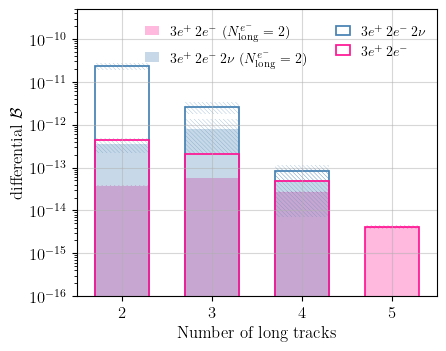

In [23]:
fig, ax = pt.std_fig()
BINS = np.linspace(0,7, 8, endpoint=True)
WIDTH=0.6

kwargs = {'lw': 0.0, 'histtype': 'barstacked', 'rwidth': WIDTH, 'alpha': 0.3, 'facecolor': 'deeppink'}
mask = ((mu5e.n_hits['e-_1'] >= 6) & (mu5e.n_hits['e-_2'] >= 6))
kwargs['label'] = r'$3e^+\, 2e^-$ ($N^{e^-}_{\rm long} = 2$)'
_ = get_histogram_and_errors(mu5e.n_long_tracks, mu5e, ax=ax, bins = BINS, color  = 'deeppink', errorbar=True, mask=mask, **kwargs)

kwargs['facecolor'] = 'steelblue'
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm long} = 2$)'
mask = ((mu5e2nu.n_hits['e-_1'] >= 6) & (mu5e2nu.n_hits['e-_2'] >= 6))
_ = get_histogram_and_errors(mu5e2nu.n_long_tracks, mu5e2nu, ax=ax, bins = BINS, color = 'steelblue', errorbar=True, mask=mask, rescale_w=1, **kwargs)


kwargs = {'lw': 1.25, 'histtype': 'barstacked', 'rwidth': WIDTH, 'facecolor': 'None'}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$'
_ = get_histogram_and_errors(mu5e2nu.n_long_tracks, mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', errorbar=True, **kwargs)
kwargs['label'] = r'$3e^+ \, 2e^-$'
_ = get_histogram_and_errors(mu5e.n_long_tracks, mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=True, **kwargs)

ax.set_ylabel(r'differential $\mathcal{B}$', fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16,5e-10)
ax.set_yticks(np.geomspace(1e-16, 1e-10, 7, endpoint=True))

ax.set_xlabel(r'Number of long tracks', fontsize=12)
ax.set_xticks(BINS+0.5)
ax.set_xticklabels([int(b) for b in BINS])
ax.set_xlim(2.,6)

ax.grid(alpha=0.5, zorder=-1)

ax.legend(frameon=False, fontsize=10, ncol=2, loc='upper right', handlelength=1, columnspacing=2, markerfirst=True)
fig.savefig('plots/all_long_tracks.pdf', dpi=400, bbox_inches='tight')

/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:24: RuntimeWarning: invalid value encountered in divide
  eps = S/N
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)


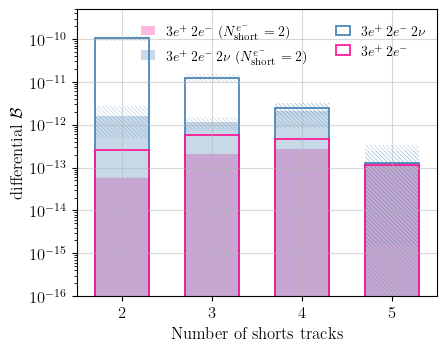

In [24]:
fig, ax = pt.std_fig()
BINS = np.linspace(0,7, 8, endpoint=True)
WIDTH=0.6

kwargs = {'lw': 0.0, 'histtype': 'barstacked', 'rwidth': WIDTH, 'alpha': 0.3, 'facecolor': 'deeppink'}
mask = ((mu5e.n_hits['e-_1'] >= 4) & (mu5e.n_hits['e-_2'] >= 4))
kwargs['label'] = r'$3e^+\, 2e^-$ ($N^{e^-}_{\rm short} = 2$)'
_ = get_histogram_and_errors(mu5e.n_short_tracks, mu5e, ax=ax, bins = BINS, color  = 'deeppink', errorbar=True, mask=mask, **kwargs)

kwargs['facecolor'] = 'steelblue'
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N^{e^-}_{\rm short} = 2$)'
mask = ((mu5e2nu.n_hits['e-_1'] >= 4) & (mu5e2nu.n_hits['e-_2'] >= 4))
_ = get_histogram_and_errors(mu5e2nu.n_short_tracks, mu5e2nu, ax=ax, bins = BINS, color = 'steelblue', errorbar=True, mask=mask, rescale_w=1, **kwargs)


kwargs = {'lw': 1.25, 'histtype': 'barstacked', 'rwidth': WIDTH, 'facecolor': 'None'}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$'
_ = get_histogram_and_errors(mu5e2nu.n_short_tracks, mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', errorbar=True, **kwargs)
kwargs['label'] = r'$3e^+ \, 2e^-$'
_ = get_histogram_and_errors(mu5e.n_short_tracks, mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=True, **kwargs)

ax.set_ylabel(r'differential $\mathcal{B}$', fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16,5e-10)
ax.set_yticks(np.geomspace(1e-16, 1e-10, 7, endpoint=True))

ax.set_xlabel(r'Number of shorts tracks', fontsize=12)
ax.set_xticks(BINS+0.5)
ax.set_xticklabels([int(b) for b in BINS])
ax.set_xlim(2.,6)

ax.grid(alpha=0.5, zorder=-1)

ax.legend(frameon=False, fontsize=10, ncol=2, loc='upper right', handlelength=1, columnspacing=2, markerfirst=True)
fig.savefig('plots/all_short_tracks.pdf', dpi=400, bbox_inches='tight')

/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:24: RuntimeWarning: invalid value encountered in divide
  eps = S/N
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)


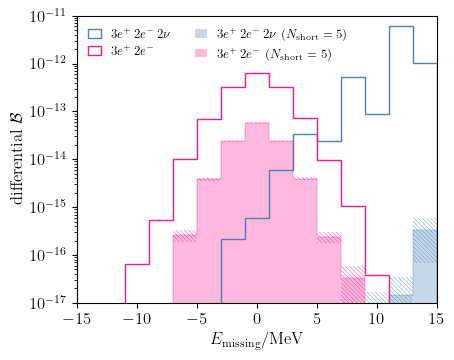

In [25]:
fig, ax = pt.std_fig()
BINS = np.linspace(-15,15,16, endpoint=True)
VAR=Emiss

kwargs = {'lw': 1, 'histtype': 'step'}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$'
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', errorbar=False, **kwargs)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs['label'] = r'$3e^+ \, 2e^-$'
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=False, **kwargs)

kwargs = {'lw': 0.0, 'histtype': 'stepfilled', 'alpha': 0.3}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$)'
kwargs['facecolor'] = 'steelblue'
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', mask=mu5e2nu.n_short_tracks == 5, **kwargs)
kwargs['label'] = r'$3e^+\, 2e^-$ ($N_{\rm short} = 5$)'
kwargs['facecolor'] = 'deeppink'
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 5, **kwargs)


kwargs = {'lw': 0.25, 'histtype': 'step', 'alpha': 1}
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', mask=mu5e2nu.n_short_tracks == 5, **kwargs)
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 5, **kwargs)


ax.set_xlabel(r'$E_{\rm missing}$/MeV', fontsize=12)
ax.set_ylabel(r'differential $\mathcal{B}$', fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-17,1e-11)
# ax.set_ylim(0,0.5e-12)
ax.set_xlim(BINS.min(),BINS.max())
ax.legend(frameon=False, fontsize=9, ncol=2, loc='upper left', handlelength=1, columnspacing=2, markerfirst=True)
fig.savefig('plots/all_missing_energy.pdf', dpi=400, bbox_inches='tight')

/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:24: RuntimeWarning: invalid value encountered in divide
  eps = S/N
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)


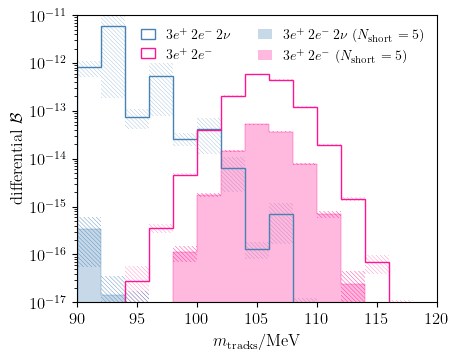

In [26]:
fig, ax = pt.std_fig()
delta = 0.15
BINS = np.linspace(90,120,16, endpoint=True)
VAR = total_inv_mass


kwargs = {'lw': 1, 'histtype': 'step'}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$'
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', errorbar=True, **kwargs)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs['label'] = r'$3e^+ \, 2e^-$'
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=True, **kwargs)

kwargs = {'lw': 0.0, 'histtype': 'stepfilled', 'alpha': 0.3}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$)'
kwargs['facecolor'] = 'steelblue'
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', mask=mu5e2nu.n_short_tracks == 5, **kwargs)
kwargs['label'] = r'$3e^+\, 2e^-$ ($N_{\rm short} = 5$)'
kwargs['facecolor'] = 'deeppink'
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 5, **kwargs)


kwargs = {'lw': 0.25, 'histtype': 'step', 'alpha': 1}
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', mask=mu5e2nu.n_short_tracks == 5, **kwargs)
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=mu5e.n_short_tracks == 5, **kwargs)


ax.set_xlabel(r'$m_{\rm tracks}$/MeV', fontsize=12)
ax.set_ylabel(r'differential $\mathcal{B}$', fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-17,1e-11)
ax.set_xlim(BINS.min(),BINS.max())
ax.legend(frameon=False, fontsize=10, ncol=2, loc='upper right', handlelength=1, columnspacing=2, markerfirst=True)
fig.savefig('plots/all_inv_mass.pdf', dpi=400, bbox_inches='tight')

In [1238]:
VAR['mu5e']

array([35.80760619, 50.5292203 , 41.65190055, ..., 20.25118928,
       42.20950754, 53.67062557])

In [ ]:
Emiss

/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:24: RuntimeWarning: invalid value encountered in divide
  eps = S/N
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: divide by zero encountered in divide
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)
/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_3970/540796841.py:25: RuntimeWarning: invalid value encountered in multiply
  eps_pred_err2 = N_pred_err2 * (S/N**2)**2  + S_pred_err2 * (1/N**2)


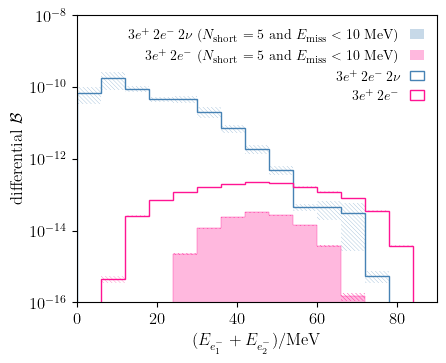

In [27]:
fig, ax = pt.std_fig()
delta = 0.15
BINS = np.linspace(0,90,16, endpoint=True)
VAR = total_eminus_energy

kwargs = {'lw': 0.0, 'histtype': 'stepfilled', 'alpha': 0.3}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$ ($N_{\rm short} = 5$ and $E_{\rm miss} < 10$ MeV)'
kwargs['facecolor'] = 'steelblue'
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', mask=((mu5e2nu.n_short_tracks == 5) & (Emiss['mu5e2nu'] <= 10)), **kwargs)
kwargs['label'] = r'$3e^+\, 2e^-$ ($N_{\rm short} = 5$ and $E_{\rm miss} < 10$ MeV)'
kwargs['facecolor'] = 'deeppink'
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=((mu5e.n_short_tracks == 5) & (Emiss['mu5e'] < 10)), **kwargs)


kwargs = {'lw': 0.25, 'histtype': 'step', 'alpha': 1}
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', mask=((mu5e2nu.n_short_tracks == 5) & (Emiss['mu5e2nu'] <= 10)), **kwargs)
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', mask=((mu5e.n_short_tracks == 5) & (Emiss['mu5e'] < 10)), **kwargs)




kwargs = {'lw': 1, 'histtype': 'step'}
kwargs['label'] = r'$3e^+\, 2e^-\, 2\nu$'
_ = get_histogram_and_errors(VAR['mu5e2nu'], mu5e2nu, rescale_w=1, ax=ax, bins = BINS, color = 'steelblue', errorbar=True, **kwargs)
# kwargs['label'] = r'$2e^+ \, 1e^-\, 2\nu$'
# _ = get_histogram_and_errors(Emiss['mu3e2nu'], mu3e2nu, ax=ax, bins = BINS, color = 'darkgrey', errorbar=False, **kwargs)
kwargs['label'] = r'$3e^+ \, 2e^-$'
_ = get_histogram_and_errors(VAR['mu5e'], mu5e, ax=ax, bins = BINS, color = 'deeppink', errorbar=True, **kwargs)


ax.set_xlabel(r'$(E_{e^-_1}+E_{e^-_2})$/MeV', fontsize=12)
ax.set_ylabel(r'differential $\mathcal{B}$', fontsize=12)
ax.set_yscale("log")
ax.set_ylim(1e-16, 1e-8)
ax.set_xlim(BINS.min(),BINS.max())
ax.legend(frameon=False, fontsize=10, ncol=1, loc='upper right', handlelength=1, columnspacing=5, markerfirst=False)
fig.savefig('plots/all_electron_energy.pdf', dpi=400, bbox_inches='tight')

## Generate many New physics cases

In [28]:
def get_events(model, nevents = 1000):
    decay = mudecays.Process(channel='mu5e', model=model, n_events=nevents)
    decay.initialize_amplitude()
    decay.generate()
    decay.evaluate_amplitude()
    decay.place_it_in_Mu3e()
    return decay

def get_Femu(decay):
    Etot = np.zeros(decay.n_events)
    tracks = decay.get_track_momenta()
    for _, track in tracks.items():
        Etot += track[:,0]
    Emiss = decay.p_parent[:,0] - Etot
    eff = decay.weights[(decay.n_short_tracks == decay.n_tracks) & (Emiss < 10)].sum()/decay.weights.sum()
    
    return np.sqrt(1e-12/(eff*decay.model.get_mu5e_BR()/decay.model.Femu**2))

def get_eff(decay):
    Etot = np.zeros(decay.n_events)
    tracks = decay.get_track_momenta()
    for _, track in tracks.items():
        Etot += track[:,0]
    Emiss = decay.p_parent[:,0] - Etot
    eff = decay.weights[(decay.n_short_tracks == decay.n_tracks) & (Emiss < 10)].sum()/decay.weights.sum()
    return eff

In [1000]:
mphis = np.array([15, 30, 45, 60, 75, 90])
map_dic = {mphi: np.linspace(2, mphi/2.05, 30, endpoint=True) for mphi in mphis}
# model_dic = {mphi: [models.DS(maprime=maprime, mphi=mphi, Femu=1e-6, epsilon=1e-4, alphaD=1/137) for maprime in map_dic[mphi]] for mphi in mphis}

# events_dic = {mphi: [get_events(model, nevents=int(1e6)) for model in model_dic[mphi]] for mphi in mphis}

In [1032]:
eff_dic = {mphi: [get_eff(decay) for decay in events_dic[mphi]] for mphi in mphis}

In [746]:
Femu_dic = {mphi: [get_Femu(decay) for decay in events_dic[mphi]] for mphi in mphis}


In [849]:
respects_unitarity = {mphi: [model.lambda_quartic < np.sqrt(4 * np.pi) for model in model_dic[mphi]] for mphi in mphis}

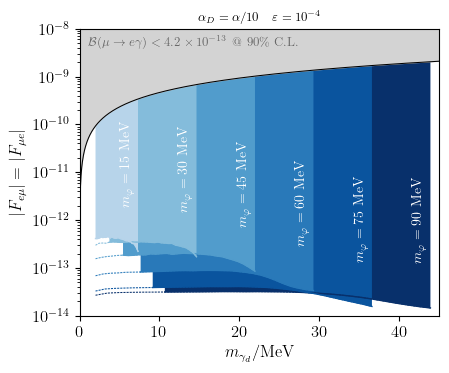

In [892]:
fig, ax = pt.std_fig()
from matplotlib.pyplot import cm

color = cm.Blues(np.linspace(0.3, 1, len(mphis)))
color2 = cm.Blues(np.linspace(0.3, 1, len(mphis)))
for mphi, c, creverse in zip(mphis[::-1], color[::-1], color2):
    mask = respects_unitarity[mphi]
    x = np.array(map_dic[mphi])
    y = np.array(Femu_dic[mphi])
    ax.plot(x[mask], y[mask], lw=1., label=rf'$m_\varphi = {mphi:.0f}$ MeV', color=c)
    ax.plot(x, y, lw=0.75, label=rf'$m_\varphi = {mphi:.0f}$ MeV', color=c, linestyle=(0,(2,1)))
    # ax.fill_between(x, y, np.ones(len(x)), lw=0, ec='None', facecolor=c, alpha=1)
    ax.fill_between(x[mask], y[mask], np.ones(len(x[mask])), lw=0, ec='None', facecolor=c, alpha=1)
    
    ax.annotate(rf"$m_\varphi = {mphi:.0f}$ MeV", xy = (map_dic[mphi][-1]-2.2,  Femu_dic[mphi][-1]*10), xycoords='data', rotation=90, fontsize=10, c='white')


x = np.linspace(0,45, 1000)
Femu_limit_Hdecays = 8.9e-11/np.sqrt(1/137*4*np.pi/10)*(x/20)
plt.fill_between(x, Femu_limit_Hdecays, np.ones(len(x)), color='lightgray')
plt.plot(x, Femu_limit_Hdecays, color='black', lw=0.75)

ax.set_xlabel(r'$m_{\gamma_d}$/MeV', fontsize=12)
ax.set_ylabel(r'$|F_{e\mu}| = |F_{\mu e}|$', fontsize=12)
# ax.legend(frameon=False, fontsize=10, ncol=1, loc='center right', handlelength=1, columnspacing=2, markerfirst=True)
ax.annotate(r'$\mathcal{B}(\mu \to e \gamma) < 4.2 \times 10^{-13}$ @ 90\% C.L.', xy=(1., 4.5e-9), fontsize=9, color='dimgrey')
# ax.annotate(r'$\mathcal{B}(\mu^+ \to e^+ \varphi)<10^{-12}$ @ Mu3e', xy=(0.04, 0.02), xycoords='axes fraction', fontsize=10, color=color[-1])
ax.set_title(r"$\alpha_D = \alpha/10 \quad \varepsilon = 10^{-4}$", fontsize=9)

ax.set_xlim(0,45)
ax.set_ylim(1e-14,1e-8)
ax.set_yscale("log")
fig.savefig('plots/sensitivity_DS.pdf', dpi=400, bbox_inches='tight')

In [1047]:
x = np.array(list(map_dic.keys())).T
Y = np.array(list(map_dic.values()))
X, _ = np.meshgrid(x,y[0])
X = X.T
Z = np.array(list(eff_dic.values()))

In [1101]:
ax_c.ax

<Axes: label='<colorbar>', ylabel='$\\varepsilon_{\\mathrm{eff}}$'>

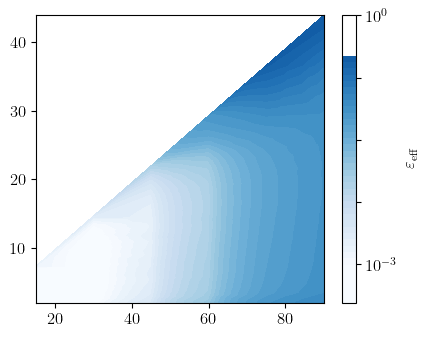

In [1108]:
from matplotlib.colors import LogNorm

fig, ax = pt.std_fig()
# _ = plt.hist2d(X.flatten(), Y.flatten(), weights=Z.flatten(), bins=100, norm=LogNorm(vmax=1,vmin=1e-4), cmap='Blues')

cs = plt.tricontourf(X.flatten(), Y.flatten(), Z.flatten(), levels=np.geomspace(Z.min(),Z.max(),40), cmap='Blues', norm=LogNorm(vmin=1e-3, vmax=1), vmin=1e-3, vmax=1)
ax_c = fig.colorbar(cs, label=r'$\varepsilon_{\mathrm{eff}}$').ax
ax_c.set_yticks(np.geomspace(1e-3,1,5))

In [920]:
X=np.meshgrid(np.array(list(map_dic.items())))

/var/folders/my/7j7cn6f92_z66yvbb11lgt2r0000gn/T/ipykernel_57856/2990146516.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X=np.meshgrid(np.array(list(map_dic.items())))


# Event displays

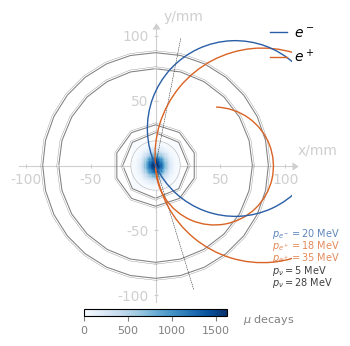

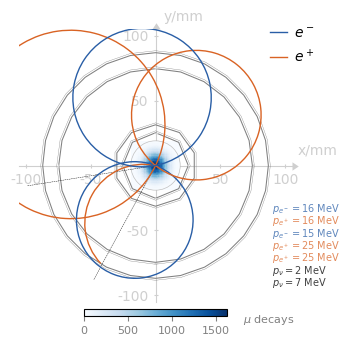

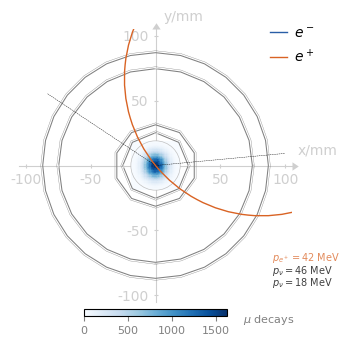

In [59]:
np.argmax(mu3e2nu.weights)

pt.EventDraw(mu3e2nu, np.argmax(mu3e2nu.n_long_tracks), draw_momentum = False, animate = False, density=mu5e)
pt.EventDraw(mu5e2nu, np.argmax(mu5e2nu.n_long_tracks), draw_momentum = False, animate = False, density=mu5e)
pt.EventDraw(mu1e2nu, np.argmax(mu1e2nu.n_long_tracks), draw_momentum = False, animate = False, density=mu5e)
pt.EventDraw(mu1e2nu, np.argmax(mu1e2nu.n_long_tracks), draw_momentum = False, animate = False, density=mu5e)

/Users/matheushostert/Repos/mu_to_5e/Mu3e/plot_tools.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


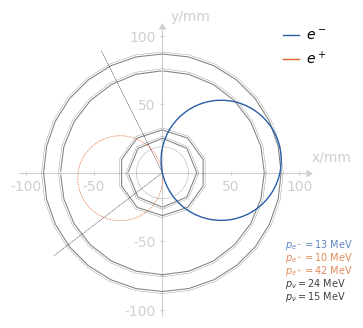

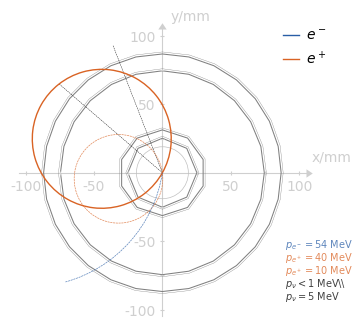

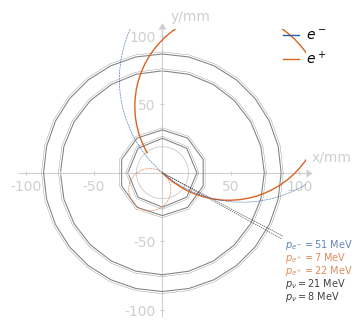

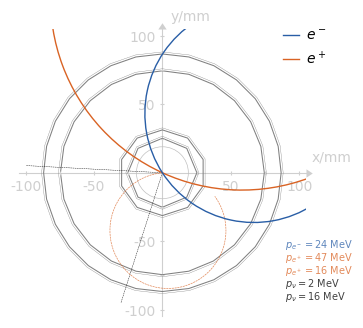

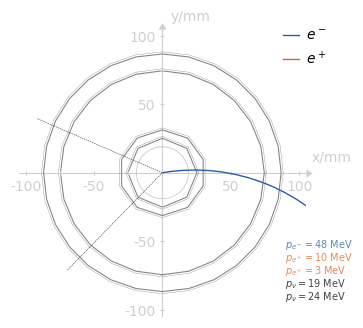

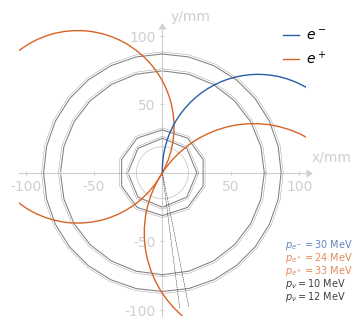

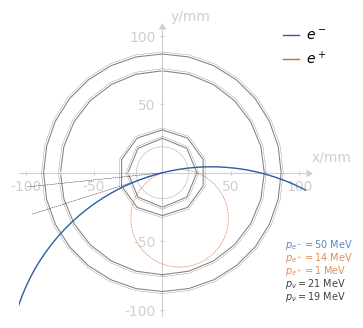

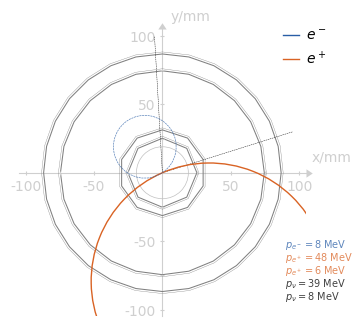

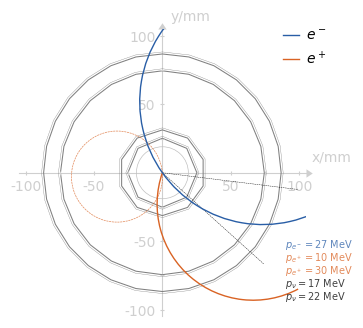

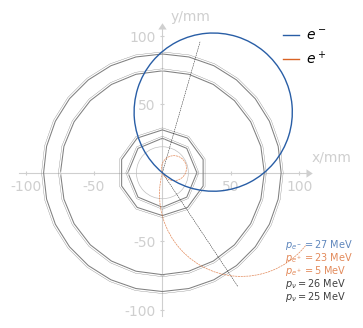

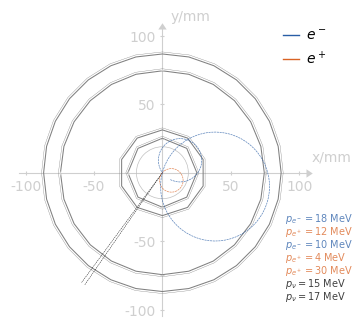

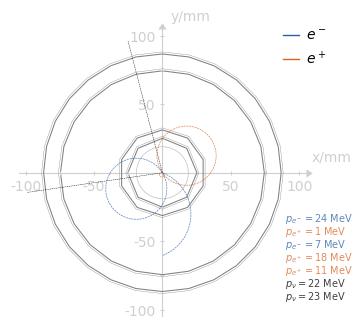

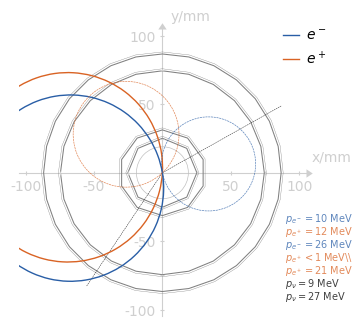

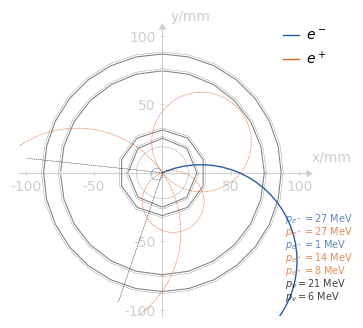

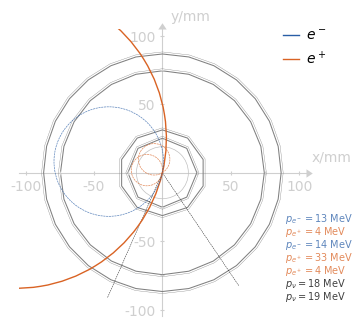

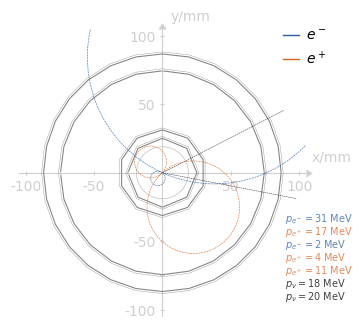

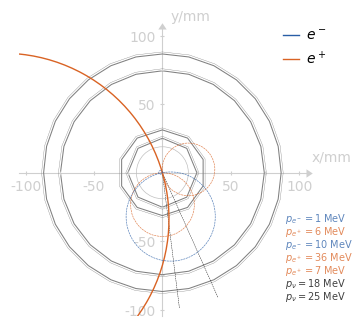

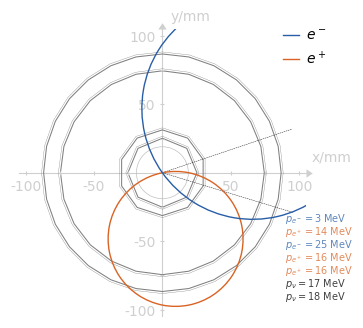

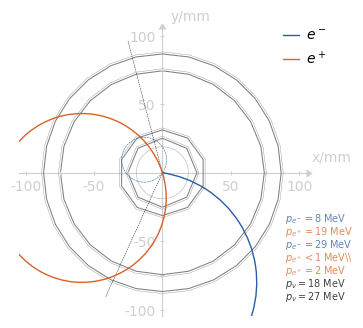

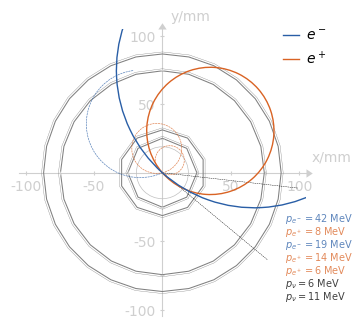

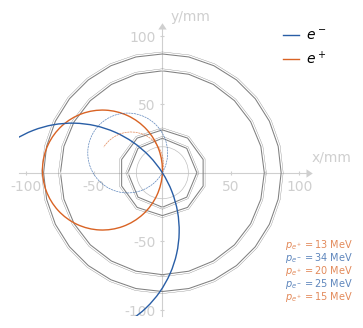

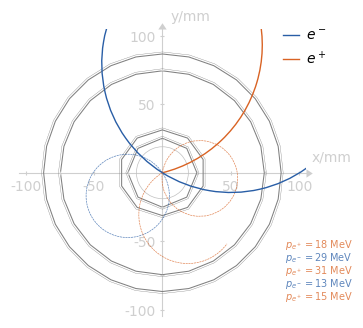

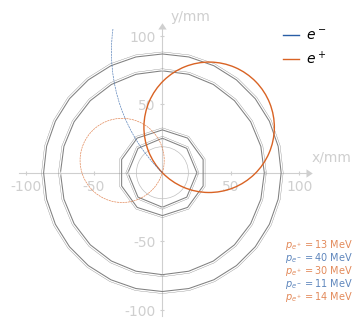

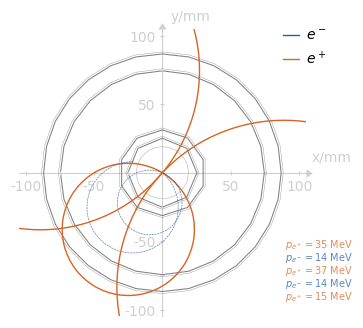

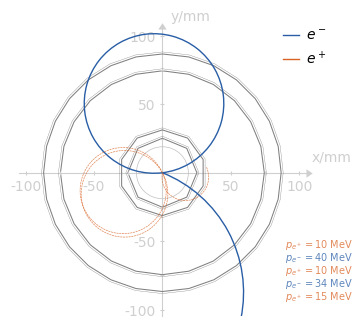

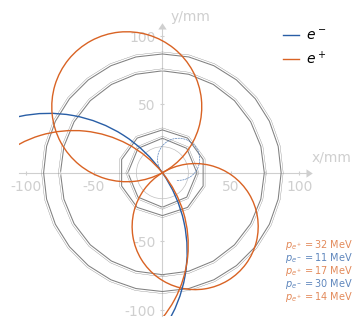

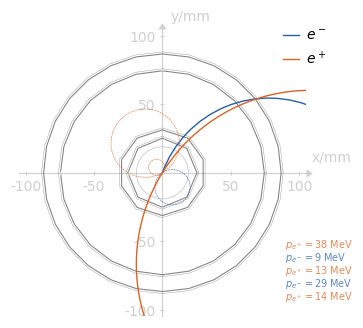

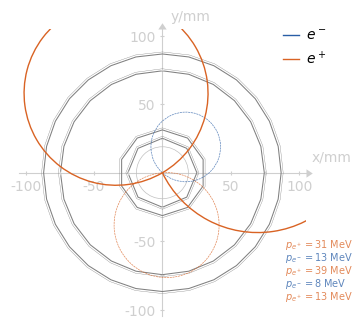

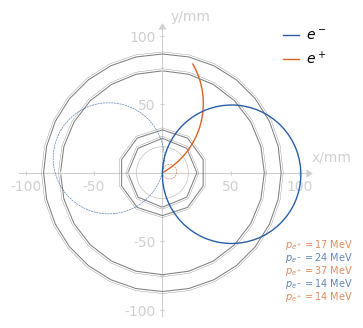

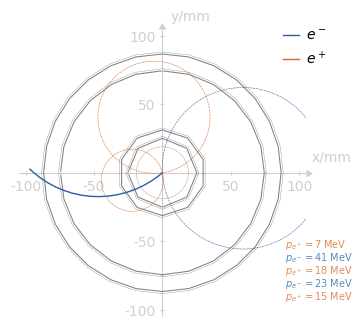

In [60]:
for i in range(0,10):
    anim = pt.EventDraw(mu3e2nu, i, draw_momentum = False, animate = False, density=False)

for i in range(0,10):
    anim = pt.EventDraw(mu5e2nu, i, draw_momentum = False, animate = False, density=False)

for i in range(0,10):
    anim = pt.EventDraw(mu5e, i, draw_momentum = False, animate = False, density=False)


## some animations?

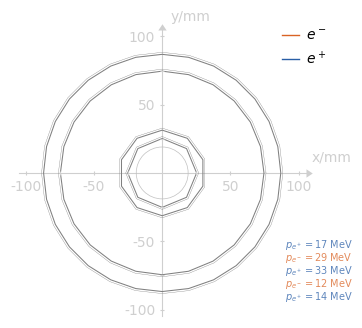

In [403]:
anim = pt.EventDraw(mu5e, 3, draw_momentum = False, animate = True, density=False)
from matplotlib import animation
# f = r"plots/animation.gif" 
# writergif = animation.PillowWriter(fps=100) 
# anim.save(f,  dpi=200, fps=1000)
anim.save('plots/animation.mp4', fps=100, dpi=300) #Frame per second controls speed, dpi       controls the quality 
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=2.0, metadata=dict(artist='M.Hostert.1'), bitrate=1800)
# anim.save('plots/animation.mp4', writer=writer, dpi=400)/

## Some details of the simulation

In [404]:
# Save to file
x, y = np.genfromtxt('Mu3e/exp_params/decays_in_z_position.dat', unpack=True)
zcoeffs = np.polyfit(x, y, 10)
zpos_fit = np.poly1d(zcoeffs)
np.save('Mu3e/exp_params/zpos_fit_pdf.npy', zpos_fit)

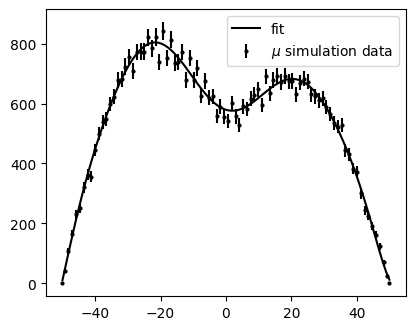

In [405]:
#data generation
fig, ax = pt.std_fig()
ax.errorbar(x, y, yerr= np.sqrt(y), linestyle='None', marker='o', color='k', markersize=2, label=r'$\mu$ simulation data')
z = np.linspace(-50,50,100)
ax.plot(z, zpos_fit(z), color='k', label='fit')
ax.legend()

In [ ]:
# nsamples = int(1e6)
# P = np.random.uniform(0,53, nsamples)
# P = dn.Cfourvec.random_normal(P, 0.2*P/P)
# phi = np.random.uniform(0,2*np.pi, nsamples)
# cphi = np.cos(phi)
# sphi = np.sin(phi)
# ctheta = np.random.uniform(-1,1, nsamples)
# stheta = np.sqrt(1 - ctheta**2)
# angle_lambda = np.pi/2 - np.arccos(ctheta)

# p = np.array([np.sqrt(P**2 + lp.e_minus.mass**2), P*stheta*cphi, P*stheta*sphi, P*ctheta]).T

array([ -6.85099323,  -2.30524055, -10.32746816, ...,  -8.64059023,
         0.70443817,   2.28979417])

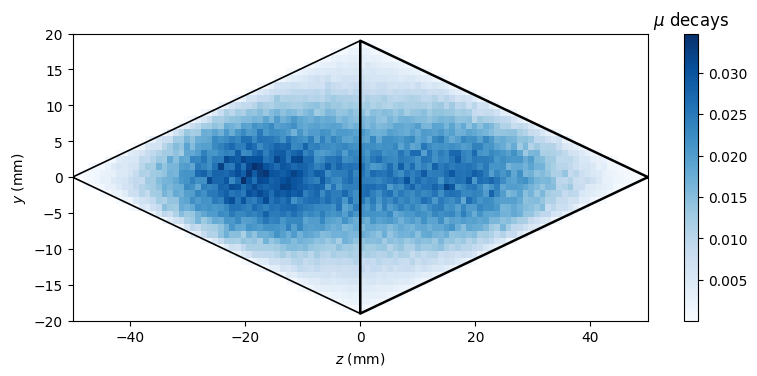

In [412]:
scale_factor = 10/5
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0]*scale_factor,pt.std_figsize[1]))

h = ax.hist2d(mu5e.z, mu5e.y, weights=mu5e.weights/np.max(mu5e.weights)/100/40, bins=(100,40), cmap='Blues', cmin=1e-100, density=False)
cb = fig.colorbar(h[3], ax=ax)
cb.ax.set_title(r"$\mu$ decays")

ax.plot([-50,0,0,-50],[0,19,-19,0], color='black', lw=1.2)
ax.plot([50,0,0,50],[0,19,-19,0], color='black', lw=1.8)

ax.set_ylim(-20,20)
ax.set_xlim(-50,50)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$y$ (mm)')

fig.savefig('plots/target_z_y.png', dpi=400, bbox_inches='tight')


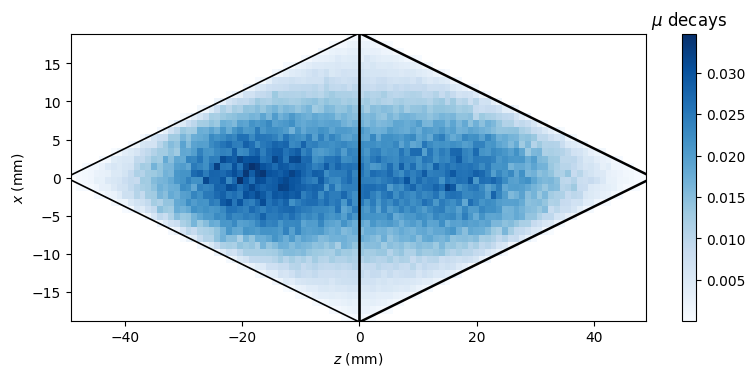

In [414]:
scale_factor = 10/5
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0]*scale_factor,pt.std_figsize[1]))

h = ax.hist2d(mu5e.z, mu5e.y, weights=mu5e.weights/np.max(mu5e.weights)/100/40, bins=(100,40), cmap='Blues', cmin=1e-100, density=False)
cb = fig.colorbar(h[3], ax=ax)
cb.ax.set_title(r"$\mu$ decays")

ax.plot([-50,0,0,-50],[0,19,-19,0], color='black', lw=1.2)
ax.plot([50,0,0,50],[0,19,-19,0], color='black', lw=1.8)

# ax.set_ylim(-20,20)
# ax.set_xlim(-50,50)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$x$ (mm)')

fig.savefig('plots/target_z_x.png', dpi=400, bbox_inches='tight')


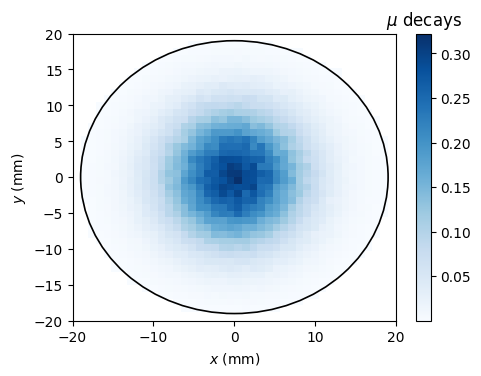

In [415]:
scale_factor = 4.5/4
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0]*scale_factor,pt.std_figsize[1]))

h = ax.hist2d(mu5e.x, mu5e.y, weights=mu5e.weights/np.max(mu5e.weights)/40/40, bins=(40,40), cmap='Blues', cmin=1e-100, density=False)
cb = fig.colorbar(h[3], ax=ax)
cb.ax.set_title(r"$\mu$ decays")

circle=plt.Circle((0,0),19, fill=False, color='black', lw=1.2)
ax.add_patch(circle)

ax.set_ylim(-20,20)
ax.set_xlim(-20,20)
ax.set_xlabel(r'$x$ (mm)')
ax.set_ylabel(r'$y$ (mm)')

fig.savefig('plots/target_x_y.png', dpi=400, bbox_inches='tight')


In [416]:
## Old stuff...


In [430]:
# vel in z direction    
beta_L = p[-1]/p[0]

# transverse p and velocity
pT = np.sqrt(p[1]**2 + p[2]**2)
beta_T = pT/p[0]
theta = np.arccos(p[-1]/(p[-1]**2 + pT**2))

arc_R = fm.radius_of_curvature(pT, Bfield=1.0)
t_exit = fm.time_of_exit(fm.layer4_L, beta_L)
max_arc_angle = t_exit*beta_T/(2*np.pi*arc_R) * 180 if arc_R > 0 else 0# degrees

max_arc_angle

0

In [256]:
from Mu3e import mudecays

In [ ]:
mudecays.

In [247]:
nsamples = int(1e6)
P = np.random.uniform(0,53, nsamples)
P = dn.Cfourvec.random_normal(P, 0.2*P/P)
phi = np.random.uniform(0,2*np.pi, nsamples)
cphi = np.cos(phi)
sphi = np.sin(phi)
ctheta = np.random.uniform(-1,1, nsamples)
stheta = np.sqrt(1 - ctheta**2)
angle_lambda = np.pi/2 - np.arccos(ctheta)

p = np.array([np.sqrt(P**2 + lp.e_minus.mass**2), P*stheta*cphi, P*stheta*sphi, P*ctheta]).T

pT = np.sqrt(p[:,1]**2 + p[:,2]**2)
pL = p[:,3]
E = p[:,0]
beta_L = pL/E
beta_T = pT/E

R_field = fm.radius_of_curvature(pT, Bfield=1.0)
# t_recurl = fm.time_of_recurl(R_field, beta)
z_recurl = t_recurl * beta_L * dm.c_light


hit_recurler = (np.abs(z_recurl) > fm.recurler_L/2 + fm.outer_recurler_gap) & (np.abs(z_recurl) < fm.recurler_L/2 + fm.recurler_L + fm.outer_recurler_gap)
long_track =  (np.abs(z_recurl) < fm.recurler_L/2) | hit_recurler
short_track = (2*R_field > 82)
cuts = short_track & long_track
# cuts = long_track

NameError: name 'R_field' is not defined

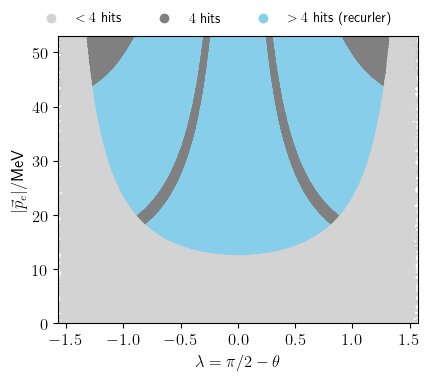

In [435]:
fig, ax = pt.std_fig()
size=5
h = ax.scatter(angle_lambda[~short_track], P[~short_track], s=size, color='lightgrey', zorder=2, edgecolor='None')
h = ax.scatter(angle_lambda[~long_track], P[~long_track], s=size, color='grey', zorder=1, edgecolor='None')
h = ax.scatter(angle_lambda[cuts], P[cuts], s=size, color='skyblue', zorder=0, edgecolor='None')

h = ax.scatter([],[], color='lightgrey', label=r'$< 4$ hits')
h = ax.scatter([],[], color='grey', label=r'$4$ hits')
h = ax.scatter([],[], color='skyblue', label=r'$> 4$ hits (recurler)')


# h = ax.hist2d(angle_lambda, P, bins=500, weights=cuts, cmap='bone_r', norm=plt.Normalize(vmin=0, vmax=1), zorder=0, alpha=0.5)

ax.set_xlabel(r'$\lambda = \pi/2-\theta$')
ax.set_ylabel(r'$|\vec{p}_e|$/MeV')
ax.set_xlim(-np.pi/2, np.pi/2)
ax.set_ylim(0,53)
fig.legend(loc='upper center', ncol=3, fontsize=10)

fig.savefig('plots/recurler_hits.png', dpi=400, bbox_inches='tight')

In [39]:
fig, ax = pt.std_fig()
size=5
# h = ax.scatter(angle_lambda[~short_track], P[~short_track], s=size, color='lightgrey', label='no hits', zorder=1, edgecolor='None')
# h = ax.scatter(angle_lambda[~long_track], P[~long_track], s=size, color='grey', label='no recurler hits', zorder=2, edgecolor='None')
# h = ax.scatter(angle_lambda[cuts], P[cuts], s=size, color='skyblue', label='recurler hits', zorder=0, edgecolor='None')

h = ax.hist2d(ctheta, P, bins=500, weights=cuts, cmap='bone_r', norm=plt.Normalize(vmin=0, vmax=1), zorder=0, alpha=0.5)

ax.set_xlabel(r'$\cos\theta$')
ax.set_ylabel(r'$|\vec{p}_e|$/MeV')
ax.set_xlim(-1, 1)
ax.set_ylim(0,60)
ax.legend(loc='upper left', ncol=3)

NameError: name 'ctheta' is not defined